In [150]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

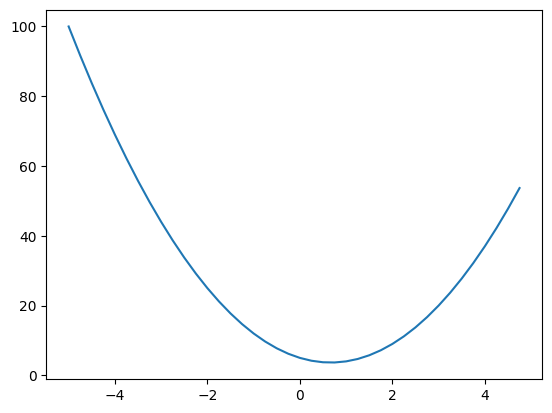

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [6]:
a = 2.0
b= -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.00001

#inputs
a = 2.0
b= -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [180]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other **-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        self._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t =  (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        def topological_sort(v):
            topo = []
            visited = set()
            
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo += topological_sort(child)
                topo.append(v)
            return topo

        ordered = topological_sort(self)
        self.grad = 1.0
        
        for node in reversed(ordered):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
d

Value(data=4.0)

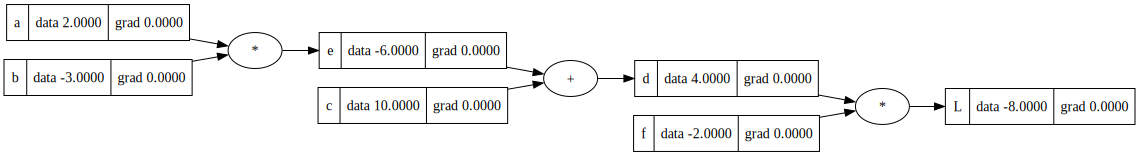

In [181]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and labels in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(L)

In [182]:
# Manual backpropagation
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad=-2.0
b.grad = -4.0
a.grad = 6.0

#Optimization step
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

#Forward pass
e = a *b
d = e + c
L = d*f

#Increased L
print(L.data)


-7.286496


In [183]:
def lol():

    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-3.9999999999995595


In [184]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.8813735870195432, label='b')

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#------------------
e = (2*n).exp(); e.label = 'e'
o = (e + 1) / (e - 1); o.label = 'o'

In [185]:
(2*n).exp()

Value(data=5.828427124746192)

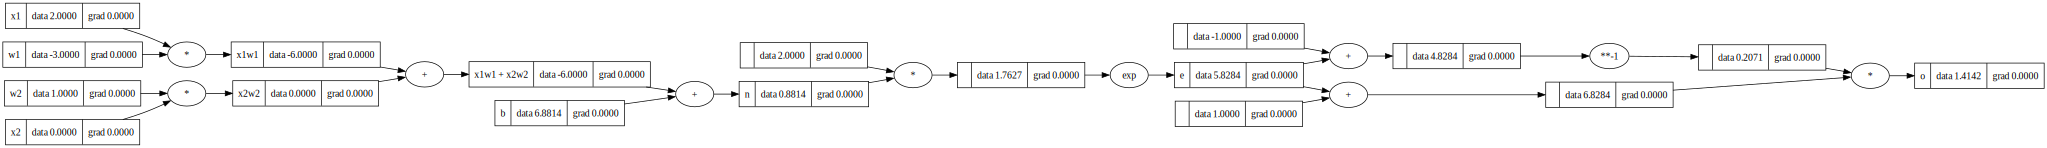

In [186]:
draw_dot(o)

In [187]:
o.backward()

In [188]:
#Manual backpropagation
o.grad = 1.0
n.grad = (1 - o.data**2)
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad

In [189]:
#Using backward implementation
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()
x2._backward()
x1._backward()
w2._backward()
w1._backward()

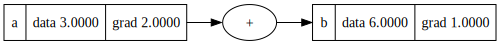

In [190]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [191]:
a * 2

Value(data=6.0)

In [192]:
#Comparing gradients with pytorch
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('----')
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())


0.7071066904050358
----
-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


In [200]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [242]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5732904628640738)

In [243]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [250]:
for k in range(20):
    
    #forward
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.0035382346289695166
1 0.0035120651952029046
2 0.0034863430331259285
3 0.0034609420785257855
4 0.0034358867826224573
5 0.0034112518901077285
6 0.0033869586660409306
7 0.0033629628732601237
8 0.0033392688124164313
9 0.0033159618958981765
10 0.0032928573595641256
11 0.0032701255037309866
12 0.0032477177173535626
13 0.0032255667340952187
14 0.0032037140093874525
15 0.0031821411954519973
16 0.0031608862820087687
17 0.00313986822465943
18 0.003119152978850424
19 0.003098698934817777
